# Chapter 3: Vector Autoregressive Methods

Prepared by: Maria Eloisa Ventura

Previously, we have introduced the classical approaches in forecasting single/univariate time series like the 
ARIMA (autoregressive integrated moving-average) model and the simple linear regression model. We learned that stationarity is a condition that is necessary when using ARIMA while this need not be imposed when using the linear regression model. In this notebook, we extend the forecasting problem to a more generalized framework where we deal with **multivariate time series**--time series which has more than one time-dependent variable. More specifically, we introduce **vector autoregressive (VAR)** models and show how they can be used in forecasting mutivariate time series. 

## Multivariate Time Series Model

As shown in the previous chapters, one of the main advantages of using simple univariate methods (e.g., ARIMA) is the ability to forecast future values of one variable by only using past values of itself. However, we know that most if not all of the variables that we observe are actually dependent on other variables. Most of the time, the information that we gather is limited by our capacity to measure the variables of interest. For example, if we want to study weather in a particular city, we could measure temperature, humidity and precipitation over time. But if we only have a thermometer, then we'll only be able to collect data for temperature, effectively reducing our dataset to a univariate time series. 

Now, in cases where we have multiple time series (longitudinal measurements of more than one variable), we can actually use multivariate time series models to understand the relationships of the different variables over time. 
By utilizing the additional information available from related series, these models can often provide better forecasts than the univariate time series models.

In this section, we cover the foundational information needed to understand Vector Autoregressive Models, a class of multivariate time series models, by using a framework similar to univariate time series laid out in the previous chapters, and extending it to the multivariate case. 

### Definition: Univariate vs Multivariate Time Series

Time series can either be univariate or multivariate. The term **univariate time series** consists of single observations recorded sequentially over equal time increments. When dealing with a univariate time series model (e.g., ARIMA), we usually refer to a model that contains lag values of itself as the independent variable. 

On the other hand, a **multivariate time series** has more than one time-dependent variable. For a multivariate process, several related time series are observed simultaneously over time. As an extension of the univariate case, the multivariate time series model involves two or more input variables, and leverages the interrelationship among the different time series variables. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import mvts_utils as utils
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

### Example 1: Multivariate Time Series

#### A. Air Quality Data from UCI

The dataset contains hourly averaged measurements obtained from an Air Quality Chemical Multisensor Device which was located on the field of a polluted area at an Italian city. The dataset can be downloaded __[here](https://archive.ics.uci.edu/ml/datasets/Air+Quality#)__.

In [2]:
aq_df = pd.read_excel("../data/AirQualityUCI/AirQualityUCI.xlsx", parse_dates=[['Date', 'Time']])\
            .set_index('Date_Time').replace(-200, np.nan).interpolate()
aq_df.head(2)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
Date_Time,,,,,,,,,,,,,,,
2004-03-10 00:00:00 18:00:00,2.6,1360.00,150.0,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754,NaN,NaN
2004-03-10 00:00:00 19:00:00,2.0,1292.25,112.0,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487,NaN,NaN


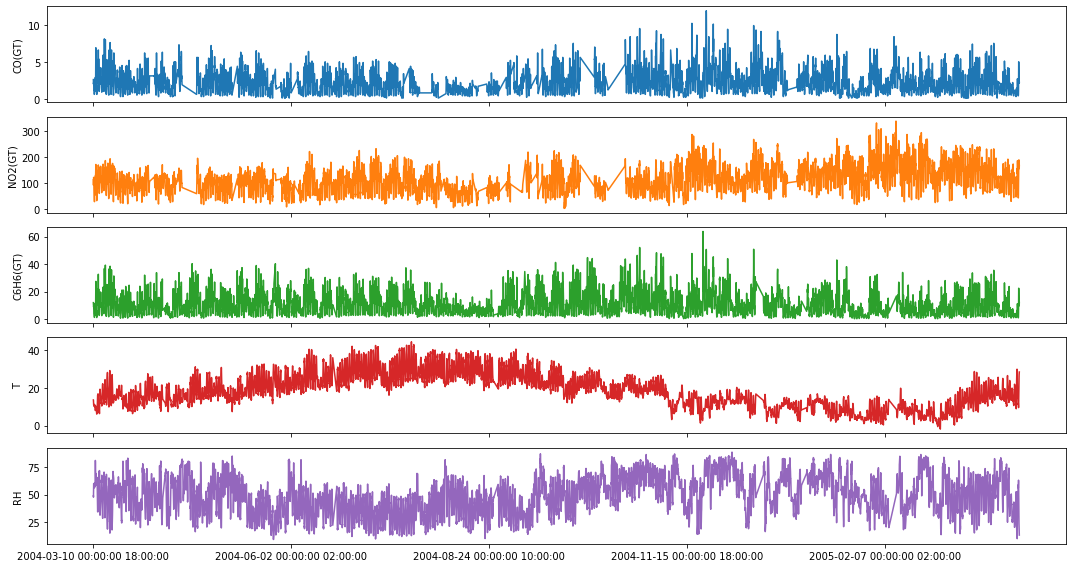

In [3]:
fig,ax = plt.subplots(5, figsize=(15,8), sharex=True)
plot_cols = ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH']
aq_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

#### B. Global Health from The World Bank

This dataset combines key health statistics from a variety of sources to provide a look at global health and population trends. It includes information on nutrition, reproductive health, education, immunization, and diseases from over 200 countries. The dataset can be downloaded __[here](https://console.cloud.google.com/marketplace/product/the-world-bank/global-health?filter=solution-type:dataset&filter=category:health&id=f3c38e10-2c45-43c8-8a12-8d749ba987ee)__.

In [4]:
ind_df = pd.read_csv('../data/WorldBankHealth/WorldBankHealthPopulation_SeriesSummary.csv')\
            .loc[:,['series_code', 'indicator_name']].drop_duplicates().reindex()\
            .sort_values('indicator_name').set_index('series_code')
hn_df = pd.read_csv('../data/WorldBankHealth/WorldBankHealthPopulation_HealthNutritionPopulation.csv')\
            .pivot(index='year', columns='indicator_code', values='value')

cols = ['SH.XPD.KHEX.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.GHED.GD.ZS']
health_expenditure_df = hn_df.loc[np.arange(2000, 2018), cols]\
    .rename(columns = dict(ind_df.loc[cols].indicator_name\
                           .apply(lambda x: '_'.join(x.split('(')[0].split(' ')[:-1]))))
health_expenditure_df.index = pd.date_range('2000-1-1', periods=len(health_expenditure_df), freq="A-DEC")
health_expenditure_df.head(3)

indicator_code,Capital_health_expenditure,Current_health_expenditure,Domestic_general_government_health_expenditure
2000-12-31,0.013654,3.154818,1.400685
2001-12-31,0.012675,2.947059,1.196554
2002-12-31,0.018476,2.733301,1.012481


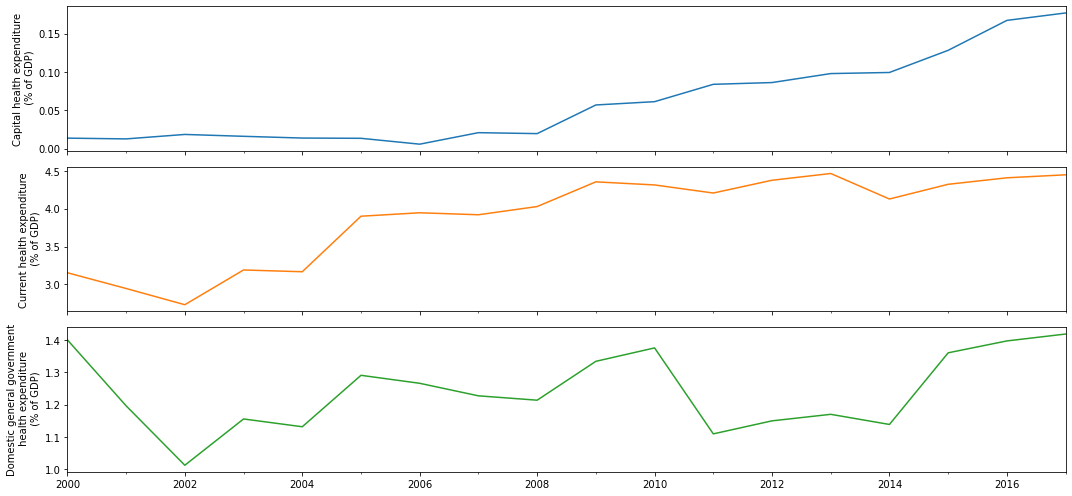

In [5]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15,7))
health_expenditure_df.plot(subplots=True, ax=ax, legend=False)
y_label = ['Capital health expenditure', 'Current health expenditure',
           'Domestic general government\n health expenditure']
for a in range(len(ax)): 
    ax[a].set_ylabel(f"{y_label[a]}\n (% of GDP)")
plt.tight_layout()
plt.show()

#### C. US Treasury Rates
January, 1982 – December, 2016  (Weekly)
https://essentialoftimeseries.com/data/
This sample dataset contains weekly data of US Treasury rates from January 1982 to December 2016. The dataset can be downloaded __[here](https://essentialoftimeseries.com/data/)__.

In [6]:
treas_df = pd.read_excel("../data/USTreasuryRates/us-treasury-rates-weekly.xlsx")
treas_df = treas_df.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
treas_df.index = pd.to_datetime(treas_df.index)
treas_df.head(3)

,1-month,3-month,6-month,1-year,2-year,3-year,5-year,7-year,10-year,Excess CRSP Mkt Returns,10-year Treasury Returns,Term spread,Change in term spread,5-year Treasury Returns,Unnamed: 15,Excess 10-year Treasury Returns,Term Spread,VXO,Delta VXO
Date,,,,,,,,,,,,,,,,,,,
1982-01-08,10.296,12.08,13.36,13.80,14.12,14.32,14.46,14.54,14.47,-1.632,NaN,2.39,NaN,NaN,NaN,-0.286662,1.729559,20.461911,-0.003106
1982-01-15,10.296,12.72,13.89,14.39,14.67,14.73,14.79,14.84,14.76,-2.212,-2.9,2.04,-0.35,1.65,-2.556,-3.758000,4.464000,NaN,NaN
1982-01-22,10.296,13.47,14.30,14.72,14.93,14.92,14.81,14.80,14.73,-0.202,0.3,1.26,-0.78,0.10,0.049,-0.558000,4.434000,NaN,NaN


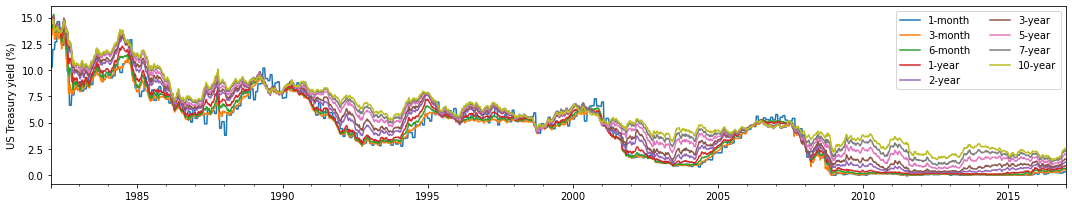

In [7]:
fig,ax = plt.subplots(1, figsize=(15, 3), sharex=True)
data_df = treas_df.iloc[:, 0:9]
data_df.plot(ax=ax)
plt.ylabel('US Treasury yield (%)')
plt.xlabel('')
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

#### D. Jena Climate Data
Time series dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany from 2009 to 2016. It contains 14 different quantities (e.g., air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes. You can download the data __[here](https://www.kaggle.com/stytch16/jena-climate-2009-2016)__.

In [8]:
jena_data = pd.read_csv('../data/jena_climate_2009_2016.csv')
jena_data['Date Time'] = pd.to_datetime(jena_data['Date Time'])
jena_data = jena_data.set_index('Date Time')
jena_data.head(3)

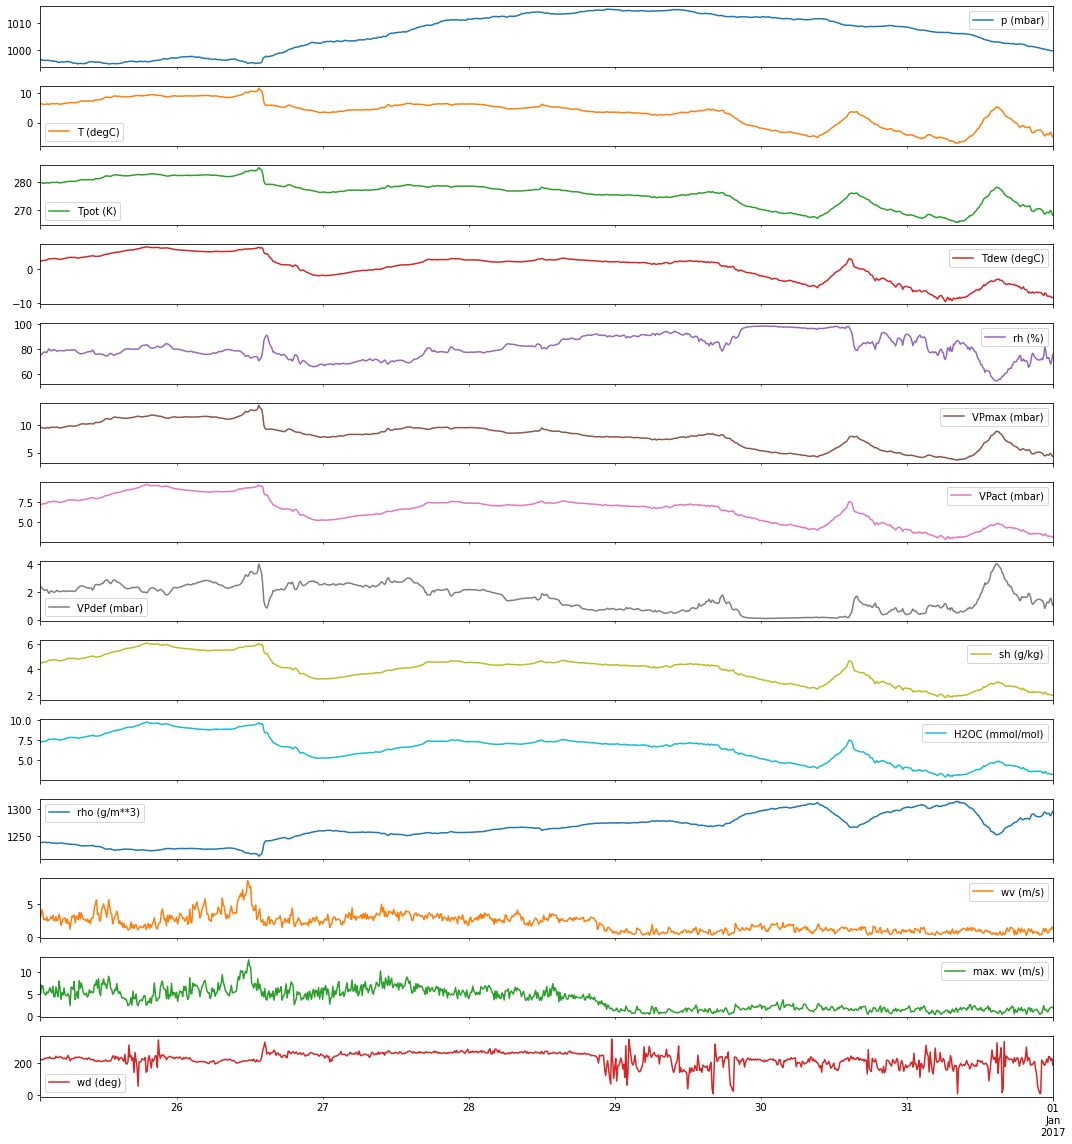

In [9]:
fig,ax = plt.subplots(jena_data.shape[-1], figsize=(15,16), sharex=True)
jena_data.iloc[-1000:].plot(subplots=True, ax=ax)
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

### Foundations
Before we discuss VARs, we outline some fundamental concepts below that we will need to understand the model. 

##### Weak Stationarity of Multivariate Time Series
As in the univariate case, one of the requirements that we need to satisfy before we can apply VAR models is stationarity--in particular, weak stationarity. Both in the univariate and multivariate case, the first two moments of the time series are time-invariant. More formally, we describe weak stationarity below. 


Consider a $N$-dimensional time series, $\mathbf{y}_t = \left[y_{1,t}, y_{2,t}, ..., y_{N,t}\right]^\prime$. This is said to be weakly stationary if the first two moments are finite and constant through time, that is,
1. $E\left[\mathbf{y}_t\right] = \boldsymbol{\mu}$
2. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_t-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_0 < \infty$ for all $t$
3. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_h$ for all $t$ and $h$

where the expectations are taken element-by-element over the joint distribution of $\mathbf{y}_t$:
- $\boldsymbol{\mu}$ is the vector of means $\boldsymbol\mu = \left[\mu_1, \mu_2, ..., \mu_N \right]$
- $\boldsymbol\Gamma_0$ is the $N\times N$ covariance matrix where the $i$th diagonal element is the variance of $y_{i,t}$, and the $(i, j)$th element is the covariance between $y_{i,t}$ and ${y_{j,t}}$
- $\boldsymbol\Gamma_h$ is the cross-covariance matrix at lag $h$

#####  Obtaining Cross-Correlation Matrix from Cross-Covariance Matrix
When dealing with a multivariate time series, we can examine the predictability of one variable on another by looking at the relationship between them using the cross-covariance function (CCVF) and cross-correlation function (CCF). To do this, we begin by defining the cross-covariance between two variables, then we estimate the cross-correlation between one variable and another variable that is time-shifted. This informs us whether one time series may be related to the past lags of the other. In other words, CCF is used for identifying lags of one variable that might be useful as a predictor of the other variable. 

**At lag 0**:

Let $\mathbf\Gamma_0$ be the covariance matrix at lag 0, $\mathbf D$ be a $N\times N$ diagonal matrix containing the standard deviations of $y_{i,t}$ for $i=1, ..., N$. The correlation matrix of $\mathbf{y}_t$ is defined as

$$\boldsymbol\rho_0 = \mathbf D^{-1}\mathbf\Gamma_0\mathbf D^{-1}$$

where the $(i, j)$th element of $\boldsymbol\rho_0$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t}$ at time $t$:

$$\rho_{i,j}(0) = \dfrac{Cov\left[y_{i,t}, y_{j,t} \right]}{\sigma_{i,t} \sigma_{j,t}}$$

**At lag h**:

Let $\boldsymbol\Gamma_h = E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right]$ be the lag-$h$ covariance cross-covariance matrix of $\mathbf y_{t}$. The lag-$h$ cross-correlation matrix is defined as

$$\boldsymbol\rho_h = \mathbf D^{-1}\mathbf\Gamma_h\mathbf D^{-1}$$

The $(i,j)$th element of $\boldsymbol\rho_h$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t-h}$:

$$\rho_{i,j}(h) = \dfrac{Cov\left[y_{i,t}, y_{j,t-h} \right]}{\sigma_{i,t} \sigma_{j,t}}$$


**What do we get from this?**

|Correlation Coefficient| Interpretation |
|:----|:----|
|$\rho_{i,j}(0)\neq0$|$y_{i,t}$ and $y_{j,t}$ are *contemporaneously linearly correlated*|
|$\rho_{i,j}(h)=\rho_{j,i}(h)=0$ for all $h\geq0$|$y_{i,t}$ and $y_{j,t}$ share *no linear relationship*|
|$\rho_{i,j}(h)=0$ and $\rho_{j,i}(h)=0$ for all $h>0$|$y_{i,t}$ and $y_{j,t}$ are said to be linearly *uncoupled*|
|$\rho_{i,j}(h)=0$ for all $h>0$, but $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *unidirectional (linear) relationship* between $y_{i,t}$ and $y_{j,t}$, where $y_{i,t}$ does not depend on $y_{j,t}$, but $y_{j,t}$ depends on (some) lagged values of $y_{i,t}$|
|$\rho_{i,j}(h)\neq0$ for at least some $h>0$ and $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *bi-directional (feedback) linear relationship* between $y_{i,t}$ and $y_{j,t}$|

## Vector Autoregressive (VAR) Models 

The vector autoregressive (VAR) model is one of the most successful models for analysis of multivariate time series. It has been demonstrated to be successful in describing relationships and forecasting economic and financial time series, and providing more accurate forecasts than the univariate time series models and theory-based simultaneous equations models. 

The structure of the VAR model is just the **generalization of the univariate AR** model. It is a system regression model that treats all the variables as endogenous, and allows each of the variables to depend on $p$ lagged values of itself and of all the other variables in the system. 

A VAR model of order $p$ can be represented as

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t = \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t$$

where $\mathbf y_t$ is a $N\times 1$ vector containing $N$ endogenous variables, $\mathbf a_0$ is a $N\times 1$ vector of constants, $\mathbf A_1, \mathbf A_2, ..., \mathbf A_p$ are the $p$ $N\times N$ matrices of autoregressive coefficients, and $\mathbf u_t$ is a $N\times 1$ vector of white noise disturbances. 

### VAR(1) Model
To illustrate, let's consider the simplest VAR model where we have $p=1$.


#### Structural and Reduced Forms of the VAR model

Consider the following bivariate system

$$ y_{1,t} = b_{1,0} - b_{1,2}y_{2,t} +  \varphi_{1,1}y_{1,t-1} + \varphi_{1,2}y_{2,t-1} + \varepsilon_{1,t}$$

$$ y_{2,t} = b_{2,0} - b_{2,1}y_{2,t} +  \varphi_{2,1}y_{1,t-1} + \varphi_{2,2}y_{2,t-1} + \varepsilon_{2,t}$$

where both $y_{1,t}$ and $y_{2,t}$ are assumed to be stationary, and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are the uncorrelated error terms with standard deviation $\sigma_{1,t}$ and $\sigma_{2,t}$, respectively. 

In matrix notation: 
<img src="bivariate1.png" style="width: 480px;"/>

Let 
<img src="bivariate2.png" style="width: 500px;"/>

then 

$$\mathbf B \mathbf y_t = \mathbf Q_0 + \mathbf Q_1 \mathbf y_{t-1} + \boldsymbol\varepsilon_t$$

##### Structural VAR (VAR in primitive form)
- Described by equation above
- Captures contemporaneous feedback effects ($b_{1,2}, b_{2,1}$)
- Not very practical to use 
- Contemporaneous terms cannot be used in forecasting
- Needs further manipulation to make it more useful (e.g. multiplying the matrix equation by $\mathbf B^{-1}$)

Multiplying the matrix equation by $\mathbf B^{-1}$, we get

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t$$

or 

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 L\mathbf y_t + \mathbf u_t$$

where $\mathbf a_0 = \mathbf B^{-1}\mathbf Q_0$, $\mathbf A_1 = \mathbf B^{-1}\mathbf Q_1$, $L$ is the lag/backshift operator, and $\mathbf u_t = \mathbf B^{-1}\boldsymbol\varepsilon_t$, equivalently,

$$ y_{1,t} = a_{1,0} + a_{1,1}y_{1,t-1} + a_{1,2}y_{2,t-1} + u_{1,t}$$

$$ y_{2,t} = a_{2,0} + a_{2,1}y_{1,t-1} + a_{2,2}y_{2,t-1} + u_{2,t}$$

##### Reduced-form VAR (VAR in standard form)
- Described by equation above
- Only dependent on lagged endogenous variables (no contemporaneous feedback)
- Can be estimated using ordinary least squares (OLS)

#### VMA infinite representation and Stationarity

Consider the reduced form, standard VAR(1) model

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t$$

Assuming that the process is weakly stationary and taking the expectation of $\mathbf y_t$, we have

$$E\left[\mathbf y_t\right] = \mathbf a_0 + \mathbf A_1 E\left[\mathbf y_{t-1}\right]$$

where $E\left[\mathbf u_t\right]=0.$ If we let $\tilde{\mathbf y}_{t}\equiv \mathbf y_t - \boldsymbol \mu$ be the mean-corrected time-series, we can write the model as

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf u_t$$

Substituting $\tilde{\mathbf y}_{t-1} = \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}$, 

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \left( \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}\right)+ \mathbf u_t$$

If we keep iterating, we get

$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \mathbf A_1^i  \mathbf u_{t-i} + \mathbf u_t$$

Letting $\boldsymbol\Theta_i\equiv A_1^i$, we get the **VMA infinite representation**


$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \boldsymbol\Theta_i  \mathbf u_{t-i} + \mathbf u_t$$



#### Stationarity of the VAR(1) model
- All the N eigenvalues of the matrix $A_1$ must be less than 1 in modulus, to avoid that the coefficient matrix $A_1^j$ from either exploding or converging to a nonzero matrix as $j$ goes to infinity.
- Provided that the covariance matrix of $u_t$ exists, the requirement that all the eigenvalues of $A_1$ are less than one in modulus is a necessary and sufficient condition for $y_t$ to be stable, and thus, stationary. 
- All roots of $det\left(\mathbf I_N - \mathbf A_1 z\right)=0$ must lie outside the unit circle. 

### VAR(p) Model

Consider the VAR(p) model described by 

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t = \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t$$

Using the lag operator $L$, we get 

$$\tilde{\mathbf A} (L) \mathbf y_t = \mathbf a_0 + \mathbf u_t$$

where $\tilde{\mathbf A} (L) = (\mathbf I_N - A_1 L - ... - A_p L^p)$. Assuming that $\mathbf y_t$ is weakly stationary, we obtain that 

$$\boldsymbol\mu = E\left[\mathbf y_t\right] = (\mathbf I_N - A_1 L - ... - A_p L^p)^{-1} \mathbf a_0$$

Defining $\tilde{\mathbf y}_t=\mathbf y_t -\boldsymbol\mu$, we have

$$\tilde{\mathbf y}_t =  \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf A_2 \tilde{\mathbf y}_{t-2} + ... + \mathbf A_p \tilde{\mathbf y}_{t-p} + \mathbf u_t$$

##### Properties
- $Cov[\mathbf y_t, \mathbf u_t] = \Sigma_u$, the covariance matrix of $\mathbf u_t$
- $Cov[\mathbf y_{t-h}, \mathbf u_t] = \mathbf 0$ for any $h>0$
- $\boldsymbol\Gamma_h = \mathbf A_1 \boldsymbol\Gamma_{h-1} +...+\mathbf A_p \boldsymbol\Gamma_{h-p}$ for $h>0$
- $\boldsymbol\rho_h = \boldsymbol \Psi_1 \boldsymbol\Gamma_{h-1} +...+\boldsymbol \Psi_p \boldsymbol\Gamma_{h-p}$ for $h>0$, where $\boldsymbol \Psi_i = \mathbf D^{-1/2}\mathbf A_i D^{-1/2}$

#####  Stationarity of VAR(p) model
- All roots of $det\left(\mathbf I_N - \mathbf A_1 z - ...-  \mathbf A_p z^p\right)=0$ must lie outside the unit circle.

### Specification of a VAR model: Choosing the order *p*

Fitting a VAR model involves the selection of a single parameter: the model order or lag length $p$. The most common approach in selecting the best model is choosing the $p$ that minimizes one or more information criteria evaluated over a range of model orders. The criterion consists of two terms: the first one characterizes the entropy rate or prediction error, and second one characterizes the number of freely estimated parameters in the model. Minimizing both terms will allow us to identify a model that accurately models the data while preventing overfitting (due to too many parameters). 

Some of the commonly used information criteria include: Akaike Information Criterion (AIC), Schwarz's Bayesian Information Criterion (BIC), Hannan-Quinn Criterion (HQ), and Akaike’s Final Prediction Error Criterion (FPE). The equation for each are shown below. 

*Akaike's information criterion*

$$(M)\operatorname{AIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + 2\dfrac{k}{T}$$

*Schwarz’s Bayesian information criterion*

$$(M)\operatorname{BIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(T)$$

*Hannan-Quinn’s information criterion*

$$(M)\operatorname{HQIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(\operatorname{ln}(T))$$

*Final prediction error*

$$\operatorname{FPE}(p) = \left(\dfrac{T+Np+1}{T-Np+1} \right)^N |\tilde{\boldsymbol\Sigma}_u | $$

$$\operatorname{ln}(\operatorname{FPE}(p)) = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + N \operatorname{ln}\left(\dfrac{T+Np+1}{T-Np+1} \right) $$



where $M$ stands for multivariate, $\tilde{\boldsymbol\Sigma}_u$ is the estimated covariance matrix of the residuals, $T$ is the number of observations in the sample, and $k$ is the total number of equations in the VAR($p$) (i.e. $N^2p + N$ where $N$ is the number of equations and $p$ is the number of lags).

Among the metrics above, AIC and BIC are the most widely used criteria, but BIC penalizes higher orders more. For moderate and large sample sizes, AIC and FPE are essentially equivalent, but FPE may outperform AIC for small sample sizes. HQ also penalizes higher order models more heavily than AIC, but less than BIC. However, under small sample conditions, AIC/FPE may outperform BIC and/or HQ in selecting true model order. 

There are cases when AIC and FPE show no clear minimum over a range or model orders or lag lengths. In this case, there may be a clear "elbow" when we plot the values over model order. This may indicate a suitable model order. 

## Building a VAR model
In this section, we show how we can use the VAR model to forecast the air quality data. The following steps are shown below: 
1. Check for stationarity.
2. Split data into train and test sets.
3. Select the VAR order *p* that gives. 
4. Fit VAR model of order *p* on the train set. 
5. Generate forecast. 
6. Evaluate model performance. 

### Example 2: Forecasting Air Quality Data (CO, NO2 and RH)

For illustration, we consider the carbon monoxide, nitrous dioxide  and relative humidity time series from the Air Quality Dataset from 1 October 2014. 

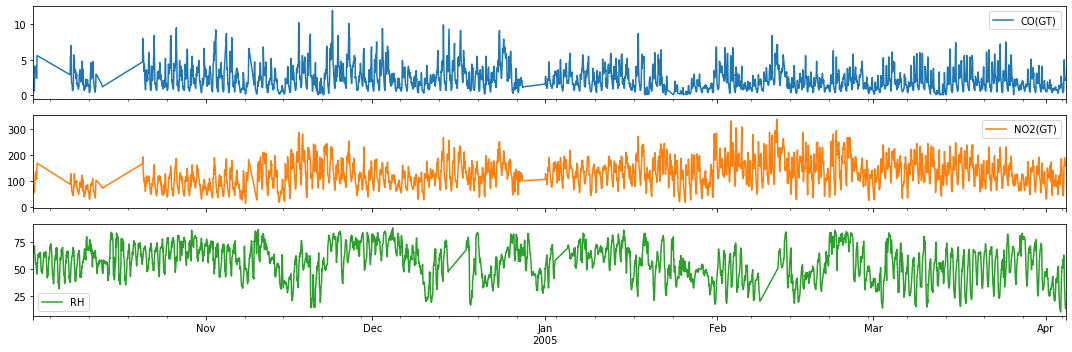

In [10]:
cols = ['CO(GT)', 'NO2(GT)', 'RH']
data_df = aq_df.loc[aq_df.index>'2004-10-01',cols]
fig,ax = plt.subplots(3, figsize=(15,5), sharex=True)
data_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

**Quick inspection before we proceed with modeling...**

To find out whether the multivariate approach is better than treating the signals separately as univariate time series, we examine the relationship between the variables using CCF. The sample below shows the CCF for the last 100 data points of the Air quality data for CO, NO2 and RH. 

*CO and NO2*

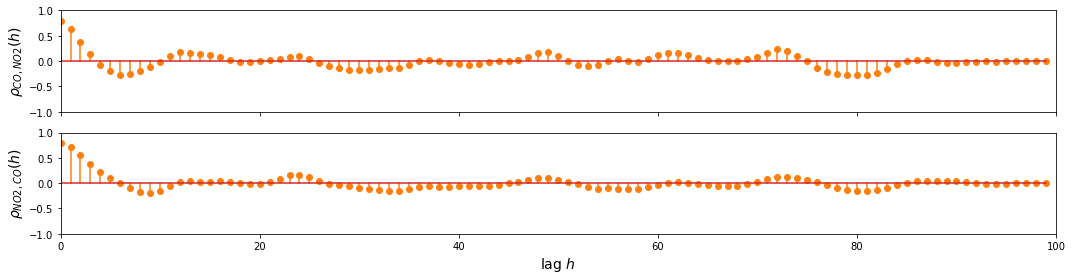

In [11]:
sample_df = data_df.iloc[-100:]
ccf_y1_y2 = ccf(sample_df['CO(GT)'], sample_df['NO2(GT)'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['NO2(GT)'], sample_df['CO(GT)'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{CO,NO2} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{NO2,CO} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

*CO and RH*

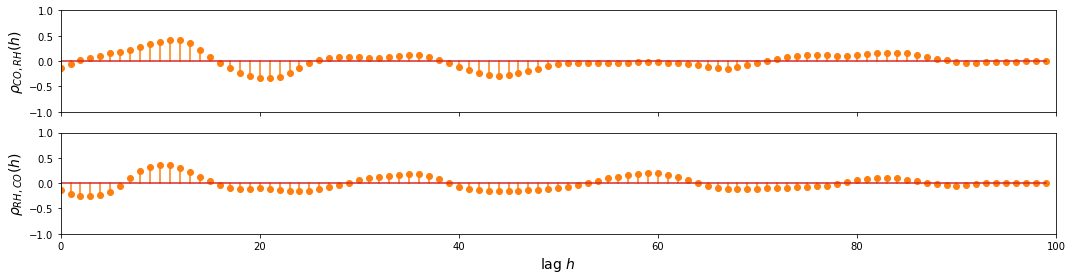

In [12]:
ccf_y1_y2 = ccf(sample_df['CO(GT)'], sample_df['RH'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['RH'], sample_df['CO(GT)'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{CO,RH} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{RH,CO} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

*RH and NO2*

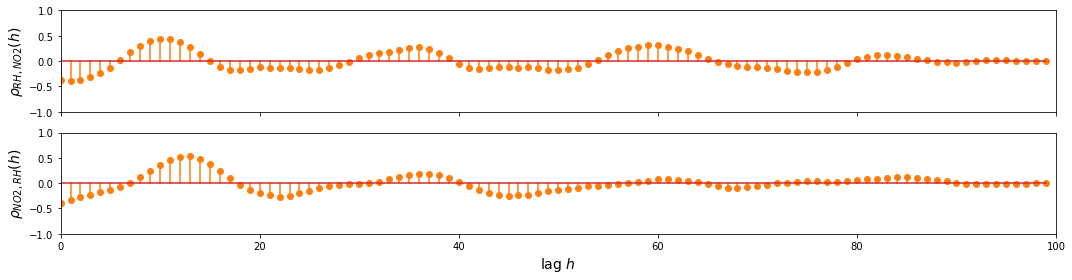

In [13]:
ccf_y1_y2 = ccf(sample_df['RH'], sample_df['NO2(GT)'], unbiased=False)
ccf_y2_y1 = ccf(sample_df['NO2(GT)'], sample_df['RH'], unbiased=False)

fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
d=1
ax[0].stem(np.arange(len(sample_df))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
ax[1].stem(np.arange(len(sample_df))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
ax[-1].set_ylim(-1, 1)
ax[0].set_xlim(0, 100)
ax[-1].set_xlabel('lag $h$', fontsize=14)
ax[0].set_ylabel(r'$\rho_{RH,NO2} (h)$', fontsize=14)
ax[1].set_ylabel(r'$\rho_{NO2,RH} (h)$', fontsize=14)
plt.tight_layout()
plt.show()

**Observation/s**: 

As shown in the plot above, we can see that there's a relationship between:
* CO and some lagged values of RH and NO2
* NO2 and some lagged values of RH and CO
* RH and some lagged values of CO and NO2

This shows that we can benefit from the multivariate approach, so we proceed with building the VAR model. 

#### 1. Check stationarity

To check for stationarity, we use the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test and the Augmented Dickey-Fuller (ADF) test. For the data to be suitable for VAR modelling, we need each of the variables in the multivariate time series to be stationary. In both tests, we need the test statistic to be less than the critical values to say that a time series (a variable) to be stationary. 

###### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
Recall: Null hypothesis is that an observable time series is stationary around a deterministic trend (i.e. trend-stationary) against the alternative of a unit root.

In [14]:
test_stat, p_val = [], []
cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
for c in data_df.columns: 
    kpss_res = kpss(data_df[c].dropna(), regression='ct')
    test_stat.append(kpss_res[0])
    p_val.append(kpss_res[1])
    cv_1pct.append(kpss_res[3]['1%'])
    cv_2p5pct.append(kpss_res[3]['1%'])
    cv_5pct.append(kpss_res[3]['5%'])
    cv_10pct.append(kpss_res[3]['10%'])
kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 2.5%': cv_2p5pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
kpss_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,0.0702,0.3239,0.1149
p-value,0.1000,0.0100,0.1000
Critical value - 1%,0.2160,0.2160,0.2160
Critical value - 2.5%,0.2160,0.2160,0.2160
Critical value - 5%,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190


**Observation/s**: 

From the KPSS test, CO and RH are stationary. 


###### Augmented Dickey-Fuller (ADF) test
Recall: Null hypothesis is that a unit root is present in a time series sample against the alternative that the time series is stationary.

In [15]:
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in data_df.columns: 
    adf_res = adfuller(data_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=data_df.columns).T
adf_res_df.round(4)

,CO(GT),NO2(GT),RH
Test statistic,-7.0195,-6.7695,-6.8484
p-value,0.0000,0.0000,0.0000
Critical value - 1%,-3.4318,-3.4318,-3.4318
Critical value - 5%,-2.8622,-2.8622,-2.8622
Critical value - 10%,-2.5671,-2.5671,-2.5671


**Observation/s**:  

From the ADF test, CO, NO2 and RH are stationary. 


#### 2. Split data into train and test sets

We use the dataset from 01 October 2014 to predict the last 24 points (24 hrs/1 day) in the dataset.

In [16]:
forecast_length = 24 
train_df, test_df = data_df.iloc[:-forecast_length], data_df.iloc[-forecast_length:]
test_df = test_df.filter(test_df.columns[~test_df.columns.str.contains('-d')])

In [17]:
train_df.reset_index().to_csv('../data/AirQualityUCI/train_data.csv')
test_df.reset_index().to_csv('../data/AirQualityUCI/test_data.csv')

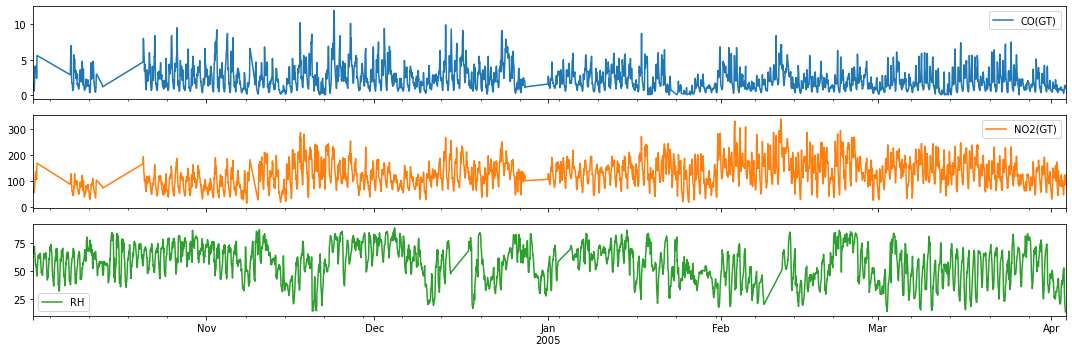

In [18]:
fig,ax = plt.subplots(3, figsize=(15, 5), sharex=True)
train_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

#### 3. Select order *p*

We compute the different multivariate information criteria (AIC, BIC, HQIC), and FPE. We pick the set of order parameters that correspond to the lowest values. 

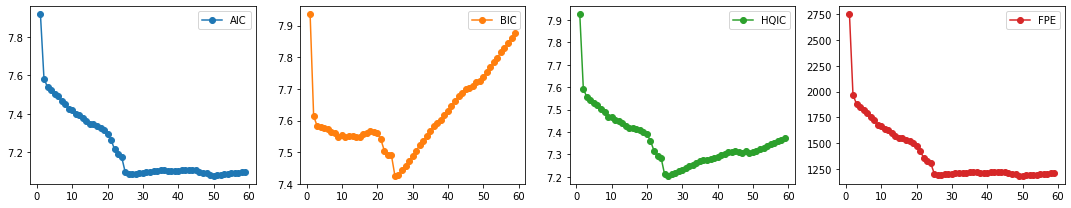

In [19]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df) 
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

**Observation/s**: 

We find BIC and HQIC to be lowest at $p=26$, and we also observe an elbow in the plots for AIC, and FPE, so we choose the number of lags to be 26. 

#### 3. Fit VAR model with chosen order

In [20]:
%%time
var_model = model.fit(26)
var_model.summary()

CPU times: user 401 ms, sys: 39.9 ms, total: 441 ms
Wall time: 202 ms


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 21, Feb, 2021
Time:                     00:47:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.42717
Nobs:                     4404.00    HQIC:                   7.20458
Log likelihood:          -34107.4    FPE:                    1191.88
AIC:                      7.08328    Det(Omega_mle):         1129.97
--------------------------------------------------------------------
Results for equation CO(GT)
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.241332         0.069966            3.449           0.001
L1.CO(GT)           0.961418         0.019229           49.999           0.000
L1.NO2(GT)          0.001992         0.000713            2.794     

#### 4. Get forecast

In [21]:
forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=forecast_length), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})

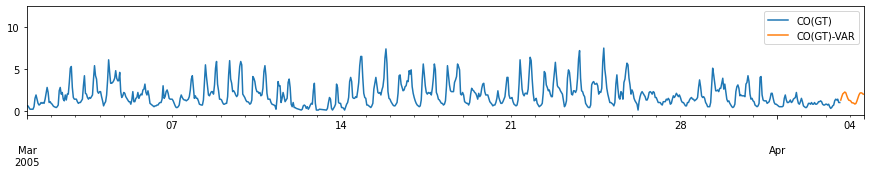

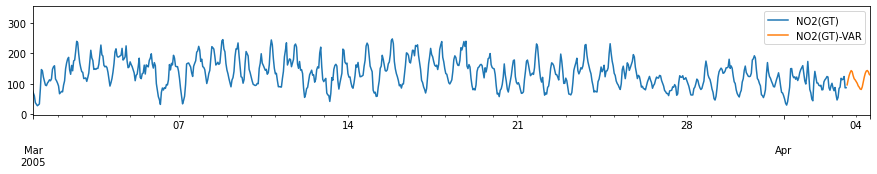

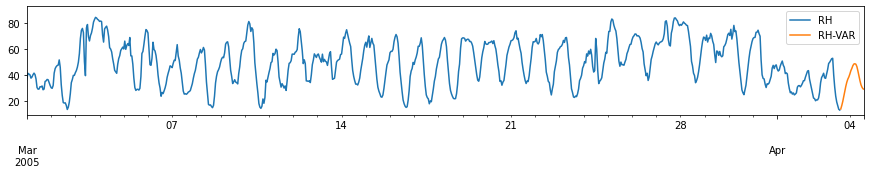

In [22]:
for c in train_df.columns:
    fig, ax = plt.subplots(figsize=[15, 2])
    pd.concat([train_df[[c]], forecast_var[[c+'-VAR']]], axis=1).plot(ax=ax)
    plt.xlim(left=pd.to_datetime('2005-03-01'))
    plt.xlabel('')
#     plt.tight_layout()
    plt.show()

#### Performance Evaluation: Comparison with ARIMA model

When using ARIMA, we treat each variable as a univariate time series, and we perform the forecasting for each variable: 1 for CO, 1 for NO2, and 1 for RH

In [23]:
# For model order selection, refer to Chapter 1
selected_order = {'CO(GT)': [(0, 1, 0)],
                  'NO2(GT)': [(0, 1, 0)],
                  'RH': [(3, 1, 1)]}

In [24]:
%%time
forecast_arima = {}
for c in cols:
    forecast_arima[c+'-ARIMA'] = utils.forecast_arima(train_df[c].values, 
                                                      test_df[c].values, 
                                                      order=selected_order[c][0])
forecast_arima = pd.DataFrame(forecast_arima, index=forecast_var.index)
forecast_arima.head()

CPU times: user 4.32 s, sys: 268 ms, total: 4.58 s
Wall time: 1.48 s


,CO(GT)-ARIMA,NO2(GT)-ARIMA,RH-ARIMA
Date_Time,,,
2005-04-03 15:00:00,0.999865,87.002935,14.502893
2005-04-03 16:00:00,0.999729,87.005870,16.743239
2005-04-03 17:00:00,0.999594,87.008806,19.253414
2005-04-03 18:00:00,0.999458,87.011741,21.715709
2005-04-03 19:00:00,0.999323,87.014676,23.974483


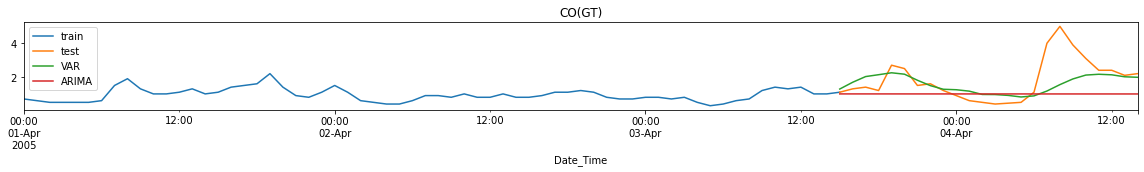

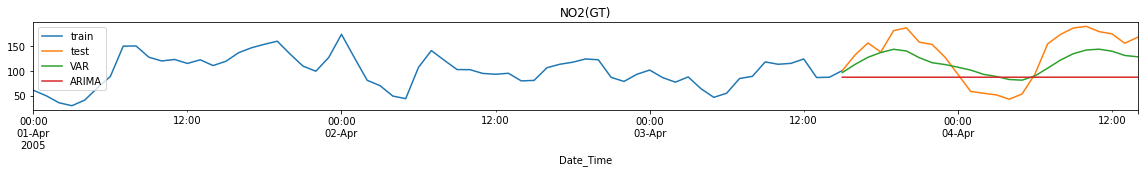

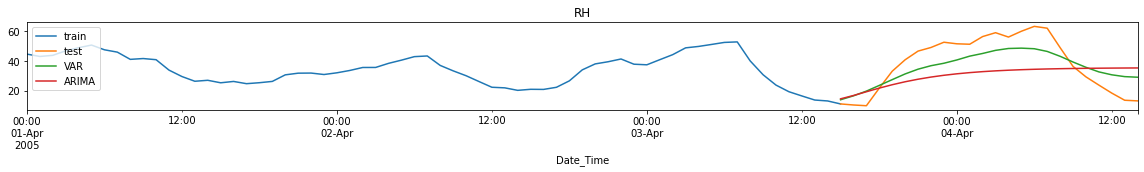

In [25]:
forecasts = pd.concat([forecast_arima, forecast_var], axis=1)
for c in cols:
    fig, ax = utils.plot_forecasts_static(train_df=train_df,
                                          test_df=test_df, 
                                          forecast_df=forecasts, 
                                          column_name=c,
                                          min_train_date='2005-04-01', 
                                          suffix=['-VAR', '-ARIMA'],
                                          title=c)


**Performance Metrics**

In [26]:
pd.concat([utils.test_performance_metrics(test_df, forecast_var, suffix='-VAR'),
           utils.test_performance_metrics(test_df, forecast_arima, suffix='-ARIMA')], axis=1)

,CO(GT)-VAR,NO2(GT)-VAR,RH-VAR,CO(GT)-ARIMA,NO2(GT)-ARIMA,RH-ARIMA
MAE,0.685005,31.687612,9.748883,1.057097,59.283376,16.239017
MSE,1.180781,1227.046604,111.996306,2.163021,4404.904459,333.622140
MAPE,43.508500,29.811066,35.565987,56.960617,46.190671,51.199023


**Observation/s**:

- MAE: VAR forecasts have lower errors than ARIMA forecasts for CO and NO2 but not in RH.
- MSE: VAR forecasts have lower errors for all variables (CO, NO2 and RH).
- MAPE: VAR forecasts have lower errors for all variables (CO, NO2 and RH). 
- Training time is significantly reduced when using VAR compared to ARIMA (<0.1s run time for VAR while ~20s for ARIMA)

## Structural VAR Analysis

In addition to forecasting, VAR models are also used for structural inference and policy analysis. In macroeconomics, this structural analysis has been extensively employed to investigate the transmission mechanisms of macroeconomic shocks (e.g., monetary shocks, financial shocks) and test economic theories. There are particular assumptions imposed about the causal structure of the dataset, and the resulting causal impacts of unexpected shocks (also called innovations or perturbations) to a specific variable on the different variables in the model are summarized. In this section, we cover two of the common methods in summarizing the effects of these causal impacts: (1) impulse response functions, and (2): forecast error variance decompositions. 

### Impulse Response Function (IRF)

- Coefficients of the VAR models are often difficult to interpret so practitioners often estimate the impulse response function. 
- IRFs trace out the time path of the effects of an exogenous shock to one (or more) of the endogenous variables on some or all of the other variables in a VAR system.
- IRF traces out the response of the dependent variable of the VAR system to shocks (also called innovations or impulses) in the error terms. 

###### IRF in the VAR system for Air Quality 

Let $y_{1,t}$, $y_{2,t}$ and $y_{3,t}$ be the time series corresponding to CO signal, NO2 signal, and RH signal, respectively. Consider the moving average representation of the system shown below:

Let 
<img src="irf_eq.png" style="width: 350px;"/>

Suppose $u_1$ in the first equation increases by a value of one standard deviation. 
- This shock will change $y_1$ in the current as well as the future periods.
- This shock will also have an impact on $y_2$ and $y_3$. 

Suppose $u_2$ in the second equation increases by a value of one standard deviation. 
- This shock will change $y_2$ in the current as well as the future periods.
- This shock will also have an impact on $y_1$ and $y_3$. 

Suppose $u_3$ in the third equation increases by a value of one standard deviation. 
- This shock will change $y_3$ in the current as well as the future periods.
- This shock will also have an impact on $y_1$ and $y_2$. 

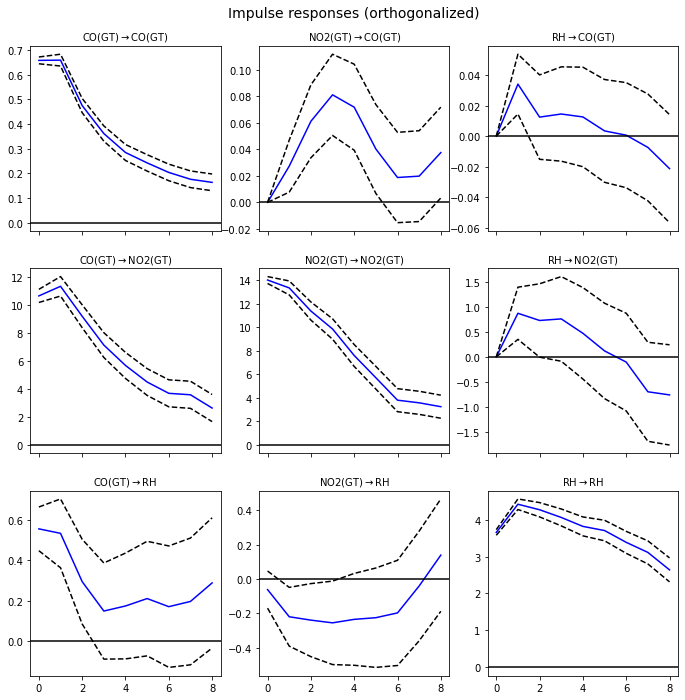

In [27]:
irf = var_model.irf(periods=8)
ax = irf.plot(orth=True, 
              subplot_params={'fontsize': 10})


**Observation/s:**

*Effects of exogenous perturbation/shocks (1SD) of a variable on itself:*

- CO $\rightarrow$ CO: A shock in the value of CO has a larger effect CO in the early hours but this decays over time. 
- NO2 $\rightarrow$ NO2: A shock in the value of NO2 has a larger effect NO2 in the early hours but this decays over time.
- RH $\rightarrow$ RH: A shock in the value of RH has a largest effect in RH after 1 hour and this effect decays over time. 

*Effects of exogenous perturbation/shocks of a variable on another:*

- CO $\rightarrow$ NO2: A shock in the value of CO has a largest effect in NO2 after 1 hour and this effect decays over time. 
- CO $\rightarrow$ RH: A shock in the value of CO has an immediate effect in the value of RH. However, the effect decreases immediately after an hour, and the value seems to stay at around 0.2.  
- NO2 $\rightarrow$ CO: A shock in NO2 only causes a small effect in the values of CO. There seems to be a delayed effect, peaking after 3 hours, but the magnitude is still small. 
- NO2 $\rightarrow$ RH: A shock in NO2 causes a small (negative) effect in the values of RH. The magnitude seems to decline further after 6 hours. The value of the IRF reaches zero in about 7 hours. 
- RH $\rightarrow$ CO: A shock in RH only causes a small effect in the values of CO.
- RH $\rightarrow$ NO2: A shock in the value of RH has a largest effect in NO2 after 1 hour and this effect decays over time. The value of the IRF reaches zero after 6 hours. 





### Forecast Error Variance Decomposition (FEVD)
- FEVD indicates the amount of information each variable contributes to the other variables in the autoregression
- While impulse response functions trace the effects of a shock to one endogenous variable on to the other variables in the VAR, variance decomposition separates the variation in an endogenous variable into the component shocks to the VAR.
- It determines how much of the forecast error variance of each of the variables can be explained by exogenous shocks to the other variables.


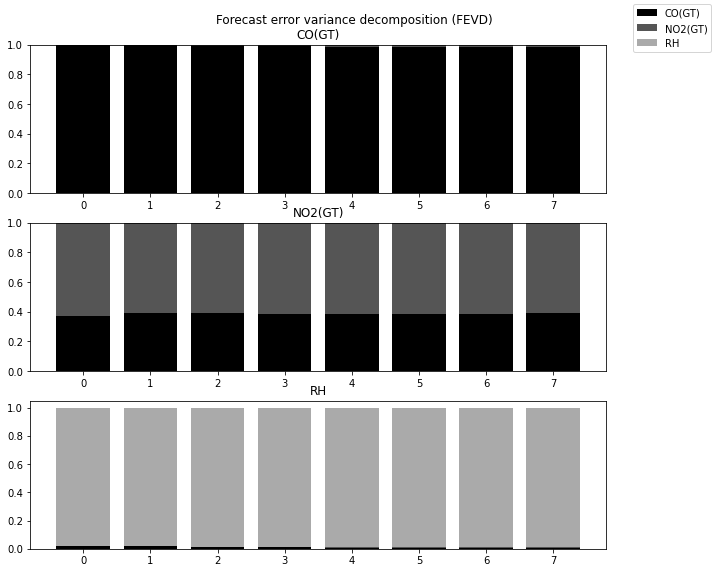

In [28]:
fevd = var_model.fevd(8)
ax = fevd.plot(figsize=(10, 8))
plt.show()

**Observation/s:**
* For CO, the variance is mostly explained by exogenous shocks to CO. This decreases over time but only by a small amount. 
* For NO2, the variance is mostly explained by exogenous shocks to NO2 and CO. 
* For RH, the variance is mostly explained by exogenous shocks to RH. Over time, the contribution of the exogenous shocks to CO increases.  

### Example 3: Forecasting the Jena climate data

We try to forecast the Jena climate data using the method outlined above. We will train the VAR model using hourly weather measurements from January 1, 2019 (00:10) up to December 29, 2014 (18:10). The performance of the model will be evaluated on the test set which contains data from December 29, 2014 (19:10) to December 31, 2014 (23:20) which is equivalent to 17,523 data points for each of the variables. 

##### Load dataset

In [29]:
train_df = pd.read_csv('../data/train_series_datetime.csv',index_col=0).set_index('Date Time')
val_df = pd.read_csv('../data/val_series_datetime.csv',index_col=0).set_index('Date Time')
test_df = pd.read_csv('../data/test_series_datetime.csv',index_col=0).set_index('Date Time')
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

In [30]:
train_val_df = pd.concat([train_df, val_df])

##### Check stationarity of each variable using ADF test

In [31]:
%%time
test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in train_val_df.columns: 
    adf_res = adfuller(train_val_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=train_df.columns).T
adf_res_df.round(4)

CPU times: user 3min 11s, sys: 25.8 s, total: 3min 37s
Wall time: 57.2 s


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Test statistic,-15.5867,-7.9586,-8.3354,-8.5750,-17.7069,-9.1945,-9.0103,-13.5492,-9.0827,-9.0709,-9.3980,-24.2424,-24.3052,-19.8394
p-value,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Critical value - 1%,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305,-3.4305
Critical value - 5%,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616,-2.8616
Critical value - 10%,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668,-2.5668


In [32]:
((adf_res_df.loc['Test statistic']< adf_res_df.loc['Critical value - 1%']) & 
(adf_res_df.loc['Test statistic']< adf_res_df.loc['Critical value - 5%']) &
( adf_res_df.loc['Test statistic']< adf_res_df.loc['Critical value - 10%']))

p (mbar)           True
T (degC)           True
Tpot (K)           True
Tdew (degC)        True
rh (%)             True
VPmax (mbar)       True
VPact (mbar)       True
VPdef (mbar)       True
sh (g/kg)          True
H2OC (mmol/mol)    True
rho (g/m**3)       True
wv (m/s)           True
max. wv (m/s)      True
wd (deg)           True
dtype: bool

**Observation/s**: 

From the values above, all the components of the Jena climate data are stationary, so we'll use all the variables in our VAR model. 

##### Select order p

CPU times: user 2min 57s, sys: 14.3 s, total: 3min 11s
Wall time: 1min


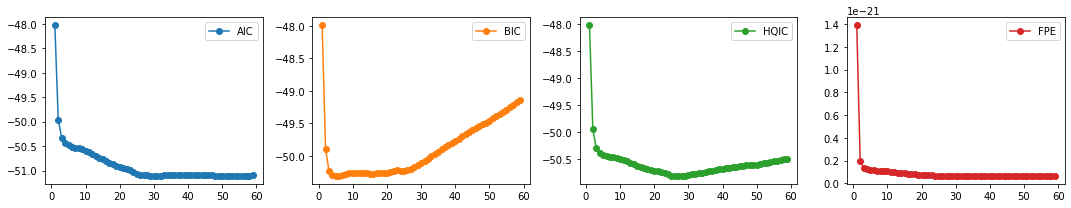

In [33]:
%%time
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_val_df)
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

In [34]:
lags_metrics_df.idxmin()

AIC     51
BIC      5
HQIC    26
FPE     51
dtype: int64

In [35]:
lags_metrics_df[25:].idxmin()

AIC     51
BIC     26
HQIC    26
FPE     51
dtype: int64

**Observation/s**: 

The model order that resulted to the minimum value varies for each information criteria, showing no clear minimum. We see an elbow at $p=5$, but if we look at AIC and HQIC we're observing another elbow/local minimum at $p=26$. So, we choose $p=26$ as our lag length. 

##### Train VAR model using the training and validation data

In [36]:
%%time
var_model = model.fit(26)

CPU times: user 1.38 s, sys: 151 ms, total: 1.53 s
Wall time: 631 ms


In [37]:
test_index = np.arange(len(test_df)- (len(test_df))%24).reshape((-1, 24))
fit_index = [test_index[:i].flatten() for i in range(len(test_index))]

##### Forecast 24-hour weather measurements and evaluate performance on test set

In [38]:
forecasts_df = []
for n in range(len(fit_index)):
    forecast_var = pd.DataFrame(var_model.forecast(
        pd.concat([train_val_df, test_df.iloc[fit_index[n]]]).values, steps=24), 
                                columns=train_val_df.columns, 
                                index=test_df.iloc[test_index[n]].index)
    forecasts_df.append(forecast_var)
forecasts_df = pd.concat(forecasts_df)
forecasts_df.columns = forecasts_df.columns+['-VAR']

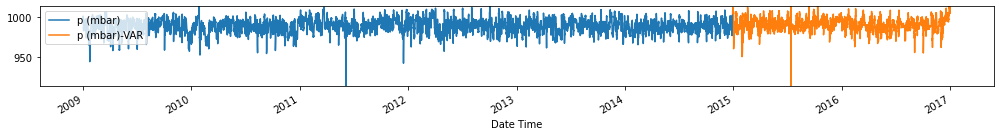

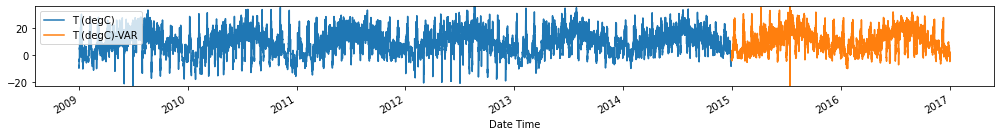

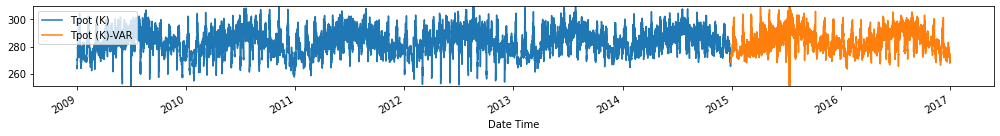

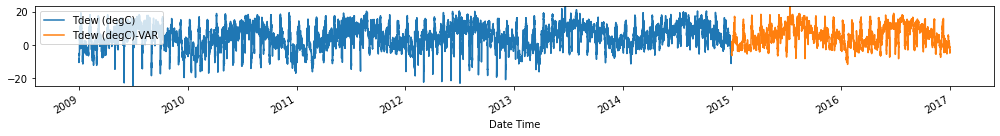

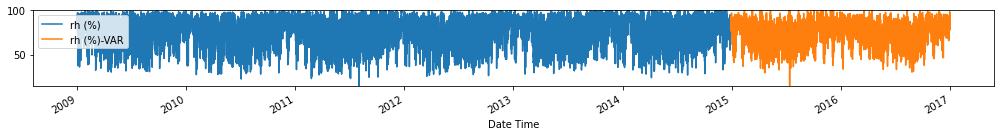

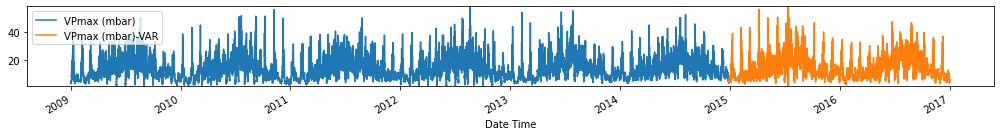

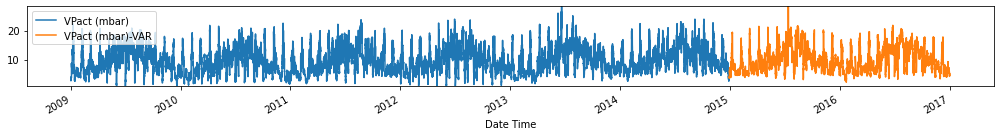

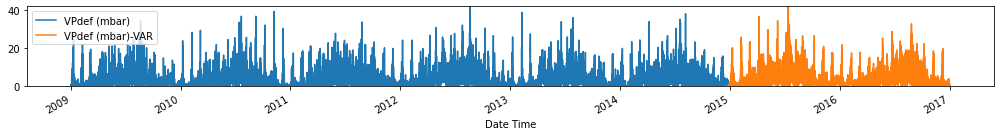

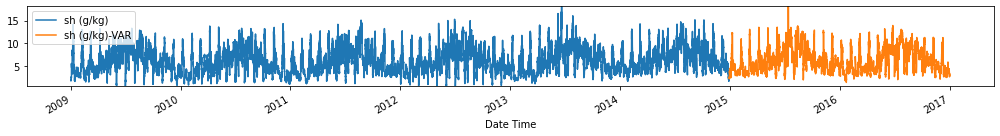

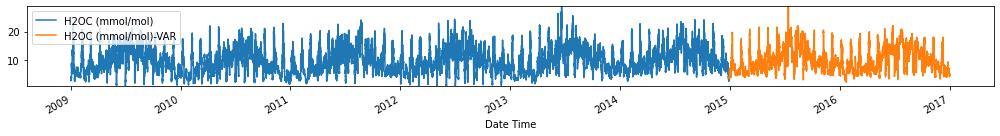

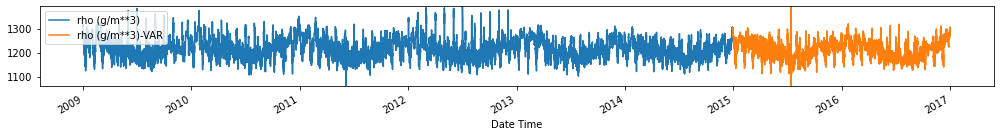

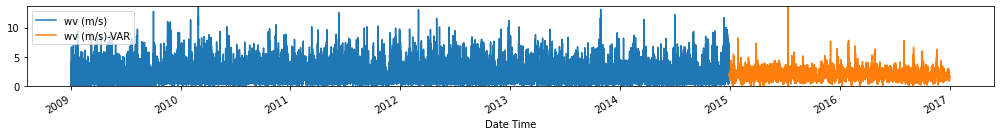

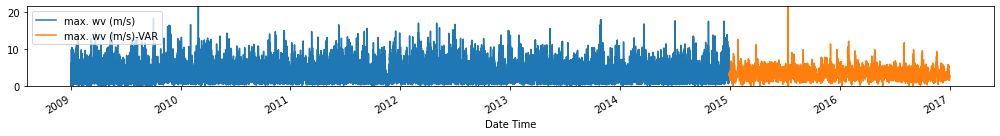

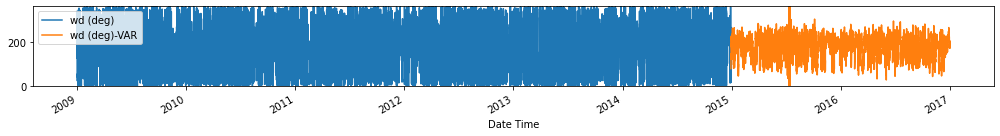

In [39]:
for c in train_val_df.columns:
    fig, ax = plt.subplots(figsize=[14, 2])
    train_val_df[c].plot(ax=ax)
    forecasts_df[[c+'-VAR']].plot(ax=ax)
    plt.ylim(train_val_df[c].min(), train_val_df[c].max())
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

***Evaluate forecasts***

In [40]:
utils.test_performance_metrics(test_df.loc[forecasts_df.index], forecasts_df, suffix='-VAR').loc[['MAE', 'MSE']]

,p (mbar)-VAR,T (degC)-VAR,Tpot (K)-VAR,Tdew (degC)-VAR,rh (%)-VAR,VPmax (mbar)-VAR,VPact (mbar)-VAR,VPdef (mbar)-VAR,sh (g/kg)-VAR,H2OC (mmol/mol)-VAR,rho (g/m**3)-VAR,wv (m/s)-VAR,max. wv (m/s)-VAR,wd (deg)-VAR
MAE,2.681284,2.542025,2.603187,1.797102,10.899944,2.526237,1.171625,2.379343,0.744665,1.186948,12.164486,3.136091,4.414089,66.420597
MSE,238.321753,652.733627,618.458262,102.257346,9581.665059,540.666240,39.837241,490.874048,15.612470,39.678736,9986.126326,17352.964659,23404.318476,87581.698748


In [41]:
T_MAEs = []
for n in range(len(test_index)):
    index = forecasts_df.iloc[test_index[n]].index
    T_MAEs.append(utils.mean_absolute_error(test_df.loc[index, 'T (degC)'].values, 
                                            forecasts_df.loc[index, 'T (degC)-VAR'].values))

In [42]:
print(f'VAR(26) MAE: {np.mean(T_MAEs)}')

VAR(26) MAE: 2.5420250169753875


**Observation/s**: The VAR(26) model outperformed the [naive (MAE= 3.18), seasonal naive (MAE= 2.61)](../08_WinningestMethods/lightgbm_jena_forecasting.ipynb) and [ARIMA (MAE= 3.19)](../01_AutoRegressiveIntegratedMovingAverage/01_AutoRegressiveIntegratedMovingAverage.ipynb) models. 

##### Forecast 24 hours beyond test set

In [43]:
all_data = pd.concat([train_df, val_df, test_df])

In [44]:
future_index = [all_data.index[-1]+pd.Timedelta(f'{h} hour') for h in np.arange(24)+1]

In [45]:
forecast_var_future = pd.DataFrame(var_model.forecast(all_data.values, 
                                                      steps=24), 
                                   columns=all_data.columns, 
                                   index=future_index)

forecast_var_future.columns = forecast_var_future.columns+['-VAR']

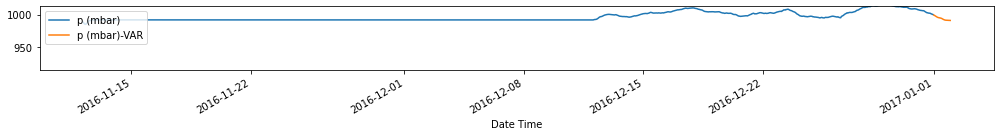

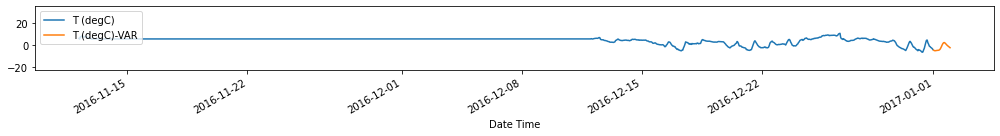

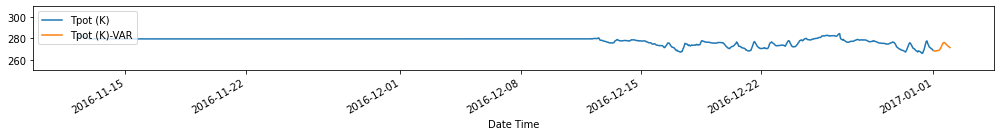

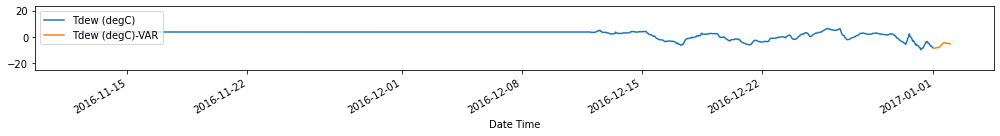

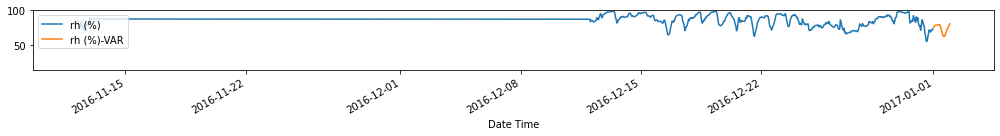

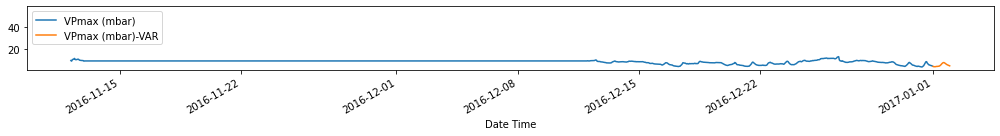

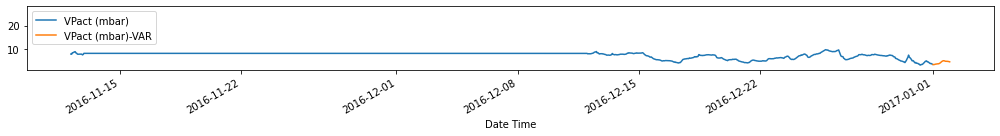

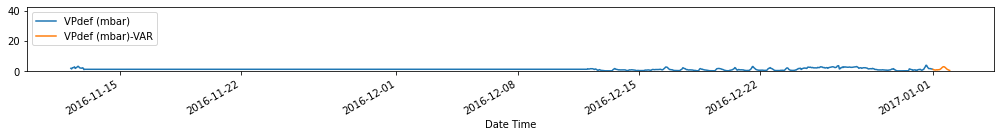

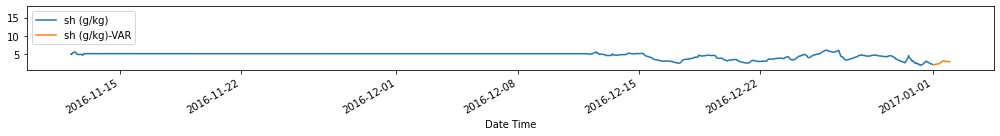

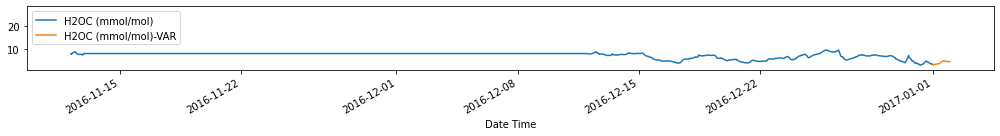

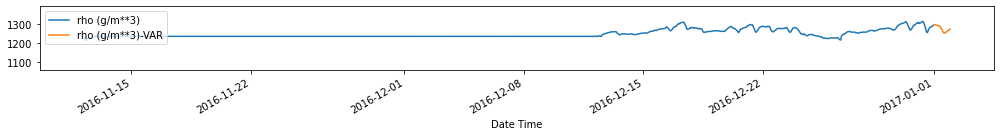

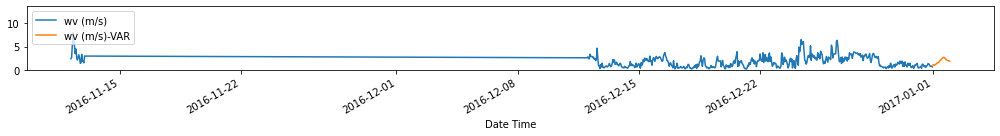

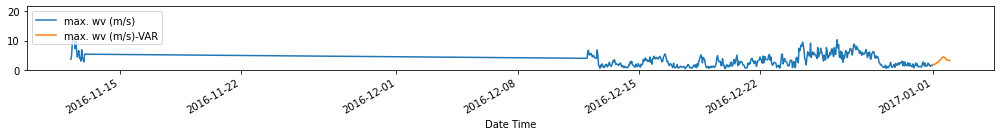

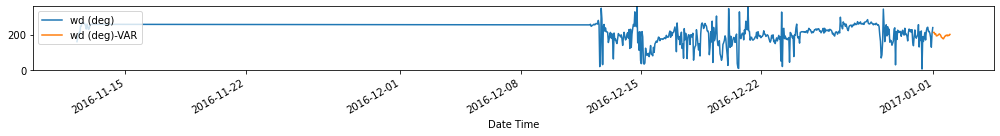

In [46]:
for c in train_val_df.columns:
    fig, ax = plt.subplots(figsize=[14, 2])
    all_data.iloc[-500:][c].plot(ax=ax)
    forecast_var_future[[c+'-VAR']].plot(ax=ax)
    plt.ylim(train_val_df[c].min(), train_val_df[c].max())
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

## Summary
* VAR methods are useful when dealing with multivariate time series, as they allow us to use the relationship between the different variable to forecast. 
* These models allow us to forecast the different variables simultaneously, with the added benefit of easy (only 1 hyperparameter) and fast training. 
* Using the fitted VAR model, we can also explain the relationship between variables, and how the perturbation in one variable affects the others by getting the impulse response functions and the variance decomposition of the forecasts. 
* However, the application of these models is limited due to the stationarity requirement for ALL the variables in the multivariate time series. This method won't work well if there is at least one variable that's non-stationary. When dealing with non-stationary multivariate time series, one can explore the use of vector error correction models (VECM). 


## Preview to the Next Chapter
In the next chapter, we further extend the use of VAR models to explain the relationships between variables in a multivariate time series using **Granger causality**, which is one of the most common ways to describe causal mechanisms in time series data.

## References
**Main references**
* Lütkepohl, H. (2005). New introduction to multiple time series analysis. Berlin: Springer.
* Kilian, L., & Lütkepohl, H. (2018). Structural vector autoregressive analysis. Cambridge: Cambridge University Press.

**Supplementary references** are listed [here](VARreferences.txt).